# Проект 4: Классификация

***
### Импорт библиотек.

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif

***
### Чтение данных, обработка пропусков и выбросов.

Посмотрим на наши данные:

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Посмотрим на наши данные. Есть информация непосредственные о клиентах:
- *age* (возраст);
- *job* (сфера занятости);
- *marital* (семейное положение);
- *education* (уровень образования);
- *default* (имеется ли просроченный кредит);
- *housing* (имеется ли кредит на жильё);
- *loan* (имеется ли кредит на личные нужды);
- *balance* (баланс).

Есть данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
- *contact* (тип контакта с клиентом);
- *month* (месяц, в котором был последний контакт);
- *day* (день, в который был последний контакт);
- *duration* (продолжительность контакта в секундах).

Также имеются другие признаки:
- *campaign* (количество контактов с этим клиентом в течение текущей кампании);
- *pdays* (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- *previous* (количество контактов до текущей кампании)
- *poutcome* (результат прошлой маркетинговой кампании).

Целевой переменной является признак *deposit*, которая определяет, согласится ли клиент открыть депозит в банке. Именно её нам требуется предсказать.

Посмотрим на типы данных:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Посмотрим на пропуски:

In [5]:
df.isna().mean().sort_values(ascending=False)*100

balance      0.223974
age          0.000000
day          0.000000
poutcome     0.000000
previous     0.000000
pdays        0.000000
campaign     0.000000
duration     0.000000
month        0.000000
contact      0.000000
job          0.000000
loan         0.000000
housing      0.000000
default      0.000000
education    0.000000
marital      0.000000
deposit      0.000000
dtype: float64

Удалим эти пропуски, поскольку их всего $0.22 \%$:

In [6]:
df = df.dropna(subset='balance')

Теперь преобразуем признак ***balance*** в тип *float*:

In [7]:
df['balance'] = df['balance'].str.replace(',','.')
df['balance'] = df['balance'].str.replace('$','')
df['balance'] = df['balance'].str.replace(' ','')
df['balance'] = df['balance'].str.strip()

df['balance'] = df['balance'].astype(float)

# посчитаем средний и медианный балансы:
balance_mean = round(df['balance'].mean(), 3)
balance_median = round(df['balance'].median(), 3)

print(f'Средний баланс: {balance_mean}, медианный баланс: {balance_median}')

Средний баланс: 1529.129, медианный баланс: 550.0


Посмотрим на признаки ***job*** и ***education***:

In [12]:
df['job'].value_counts()

management       2560
blue-collar      1938
technician       1816
admin.           1334
services          920
retired           775
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [11]:
df['education'].value_counts()

secondary    5464
tertiary     3681
primary      1495
unknown       497
Name: education, dtype: int64

Заменим значения *unknown* на модальные:

In [13]:
job_mode = df['job'].mode()[0]
edu_mode = df['education'].mode()[0]

df['job'] = df['job'].apply(lambda x: job_mode if x=='unknown' else x)
df['education'] = df['education'].apply(lambda x: edu_mode if x=='unknown' else x)

Теперь поработаем с выбросами. Построим коробчатую диаграмму для признака ***balance***:

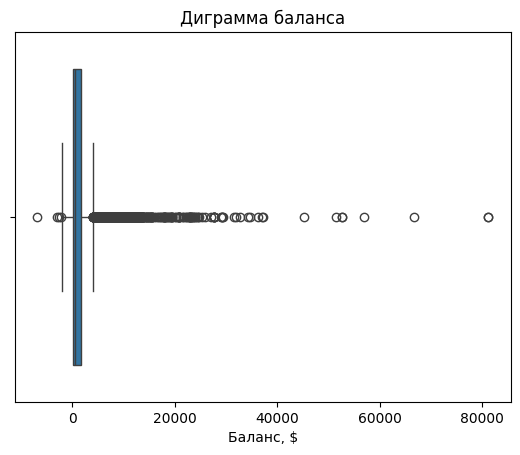

In [19]:
sns.boxplot(df['balance'], orient='h')

plt.title('Диграмма баланса')
plt.xlabel('Баланс, $')
plt.show();

Поскольку у нас присутствуют значения, которые можно считать выбросами, проведём очистку по методу Тьюки:

In [20]:
# функция удаления выбросов по методу Тьюки
def outliers_iqr(data, feature, q=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * q)
    upper_bound = quartile_3 + (iqr * q)
    outliers = data[(x <= lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x <= upper_bound)]
    bounds = (lower_bound, upper_bound)
    return outliers, cleaned, bounds

print('Количество наблюдений до удаления выбросов: ', df.shape[0])
_, df, bounds = outliers_iqr(df, 'balance')
print('Количество наблюдений после удаления выбросов: ', df.shape[0])
print('Межквартильный размах: ', bounds)

Количество наблюдений до удаления выбросов:  11137
Количество наблюдений после удаления выбросов:  10084
Межквартильный размах:  (-2254.5, 4085.5)


***
### Разведочный анализ данных.

Посмотрим на соотношение классов в наших данных:

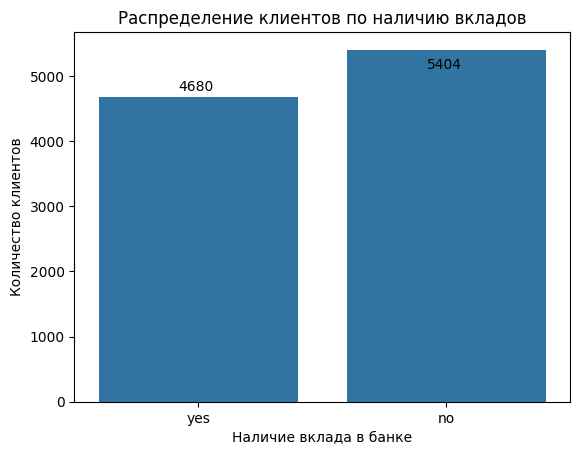

In [21]:
count_yes = df.loc[df['deposit'] == 'yes', 'deposit'].count()
count_no = df.loc[df['deposit'] == 'no', 'deposit'].count()

sns.countplot(x=df['deposit'])

plt.title('Распределение клиентов по наличию вкладов')
plt.xlabel('Наличие вклада в банке')
plt.ylabel('Количество клиентов')
plt.text(-0.08, count_yes + 100, count_yes)
plt.text(0.92, count_no - 300, count_no);

Классы сбалансированы.

Теперь разделим наши признаки на количественные и категориальные:

In [22]:
types = df.dtypes
num_features = list(types[(types != 'object')].index)
cat_features = list(types[(types == 'object')].index)

Посмотрим на количественные признаки:

In [23]:
df[num_features].describe()

,age,balance,day,duration,campaign,pdays,previous
count,10084.000000,10084.000000,10084.000000,10084.000000,10084.000000,10084.000000,10084.000000
mean,40.901726,809.587069,15.585879,368.926121,2.515569,51.376140,0.817136
std,11.741909,997.223584,8.437886,346.702597,2.706558,109.720365,2.245712
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,94.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,443.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1228.000000,22.000000,491.000000,3.000000,2.000000,1.000000
max,95.000000,4079.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


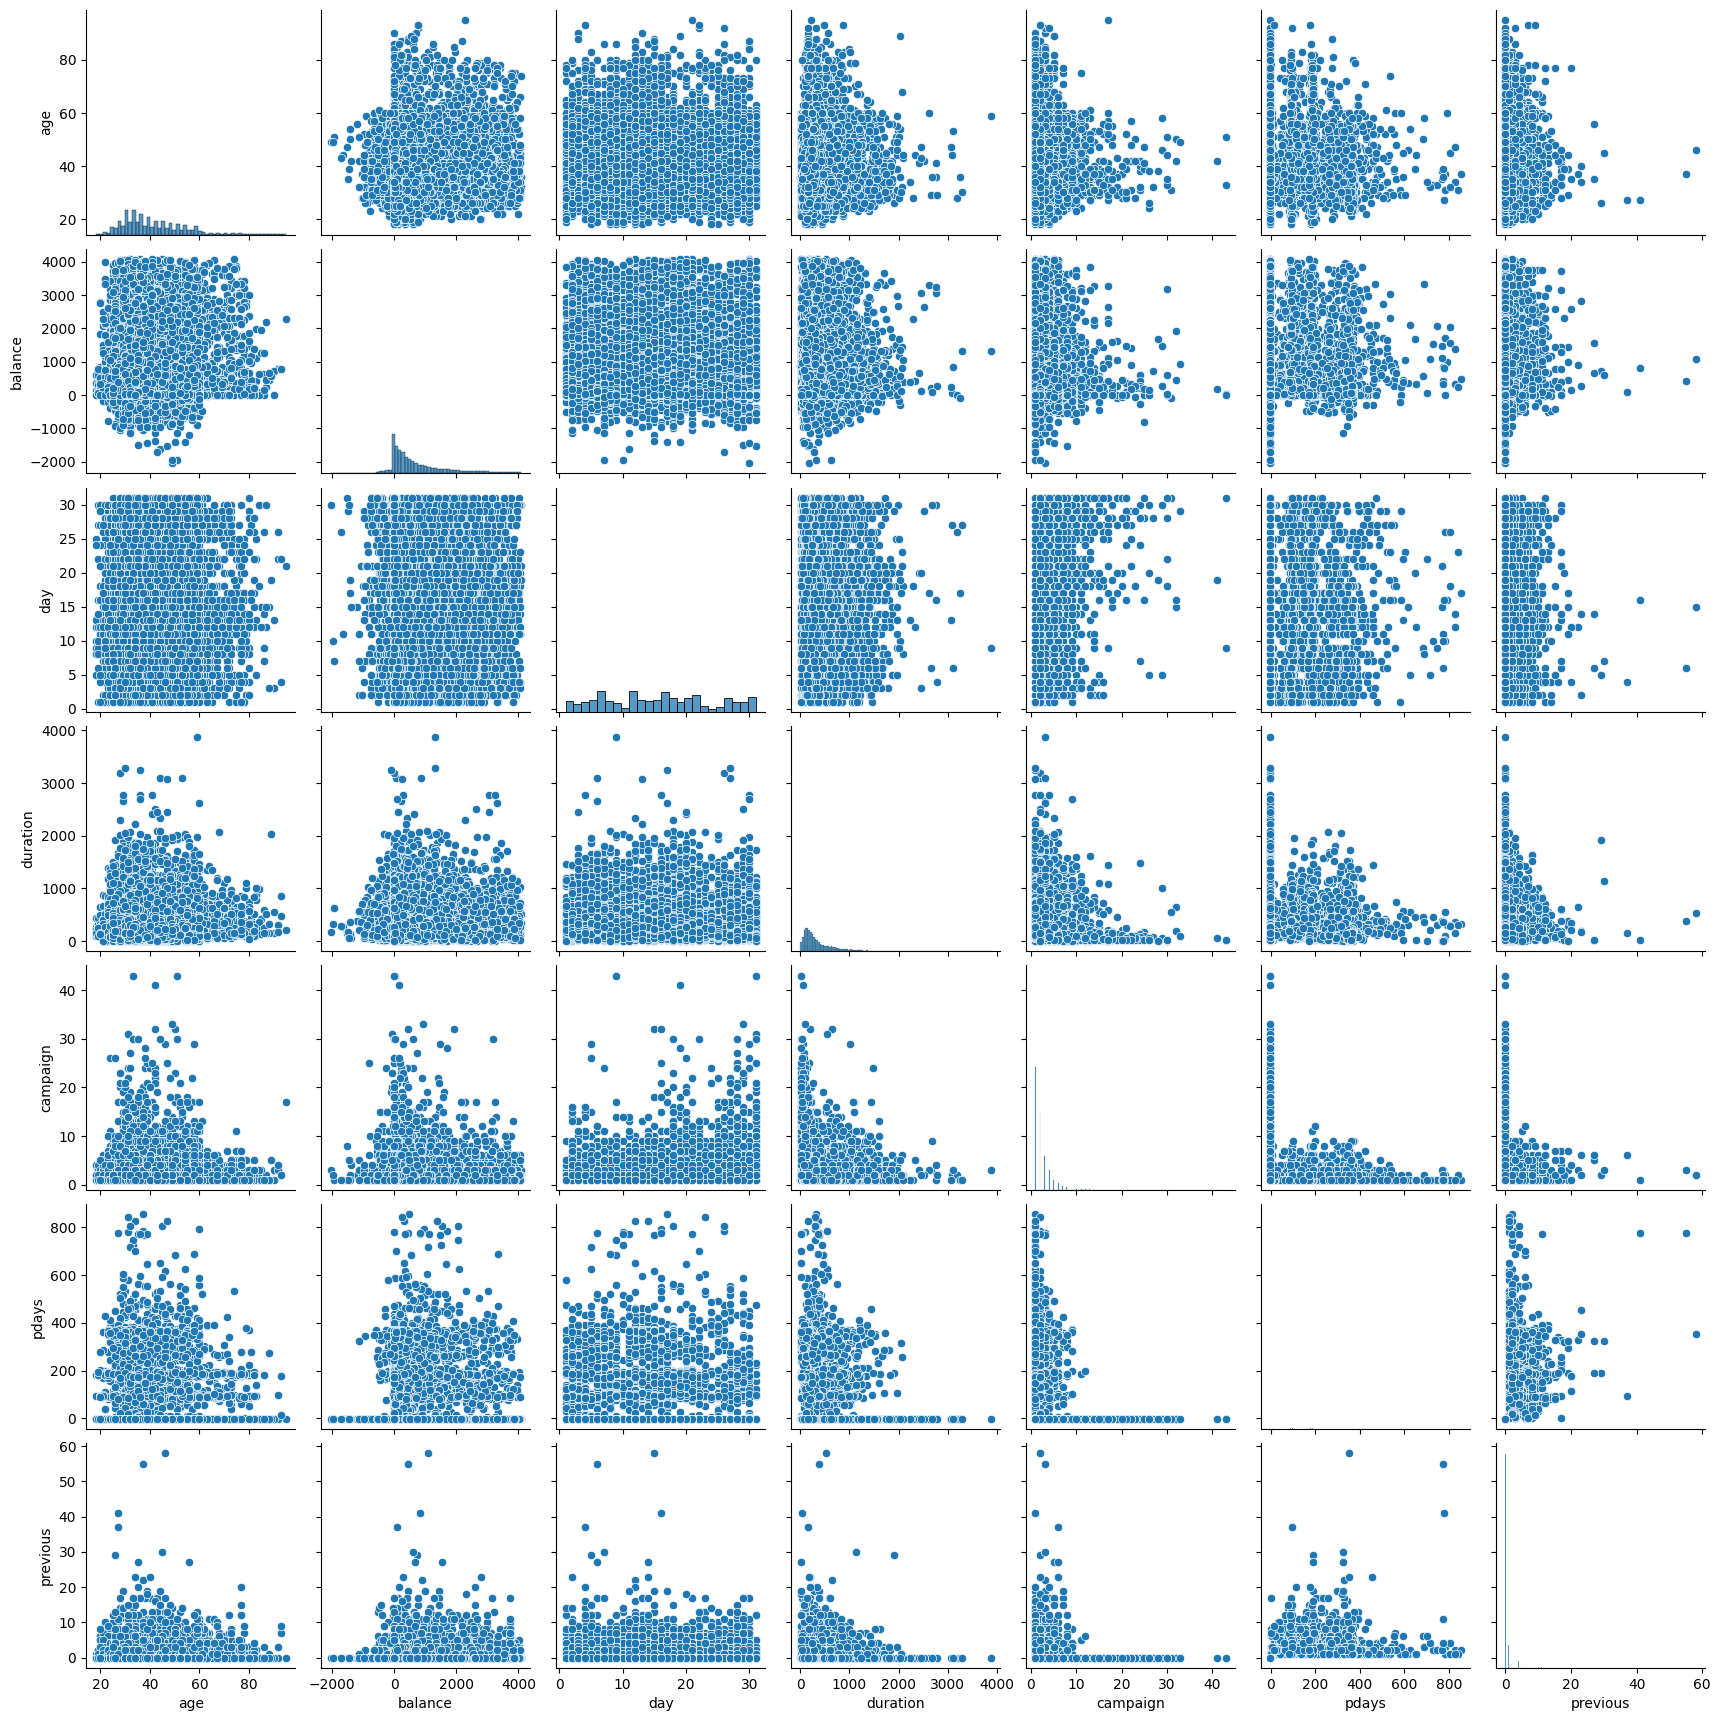

In [25]:
sns.pairplot(df[num_features]);

Какие-то взаимозависимости заметить сложно. Посмотрим подробности.

Построим коробчатые диаграммы для некоторых признаков:

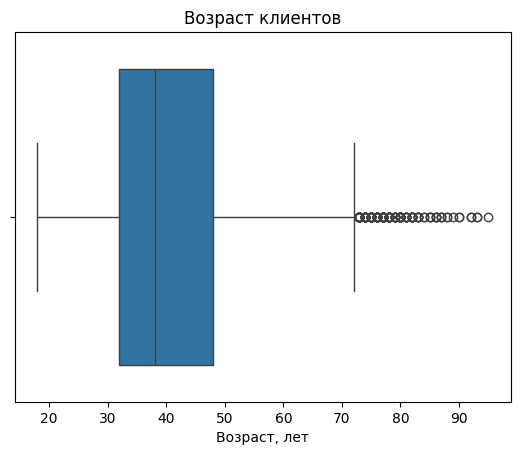

In [26]:
sns.boxplot(df['age'], orient='h')

plt.title('Возраст клиентов')
plt.xlabel('Возраст, лет')
plt.show();

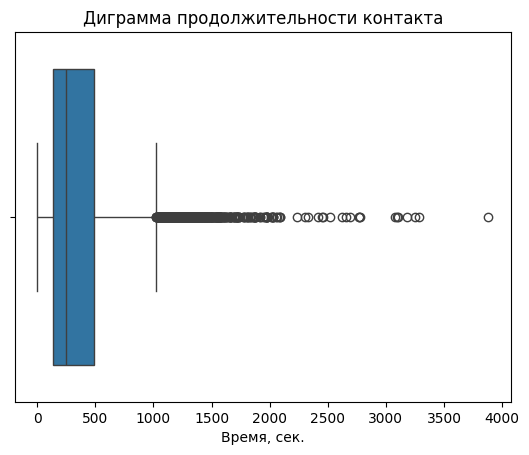

In [27]:
sns.boxplot(df['duration'], orient='h')

plt.title('Диграмма продолжительности контакта')
plt.xlabel('Время, сек.')
plt.show();

Крайние правые значения похожи на выбросы. Посмотрим на них в разрезе возраста и целевого признака:

In [33]:
df.loc[df['duration'] > 2000, ['duration', 'age', 'deposit']]

,duration,age,deposit
22,2087,43,yes
153,3094,44,yes
223,2456,47,yes
261,2653,29,yes
271,3881,59,yes
306,2769,36,yes
312,2621,60,yes
358,3183,28,yes
427,2029,54,yes
586,2015,51,yes


Можно предположить, что большая длительность разговора связана с техническими деталями интересующими клиентов, поэтому оставим эти значения.

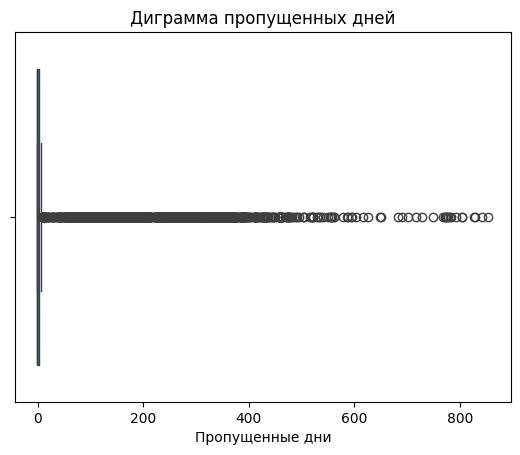

In [37]:
sns.boxplot(df['pdays'], orient='h')

plt.title('Диграмма пропущенных дней')
plt.xlabel('Пропущенные дни')
plt.show();

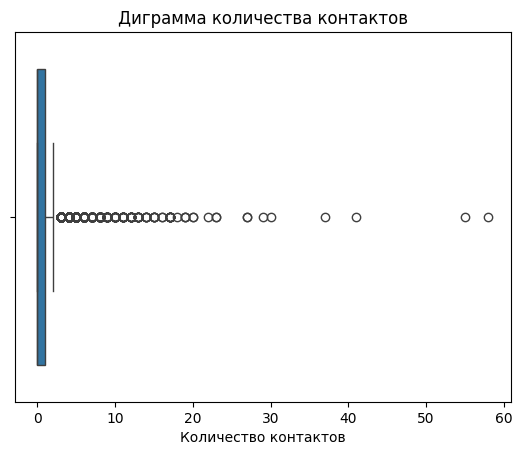

In [36]:
sns.boxplot(df['previous'], orient='h')

plt.title('Диграмма количества контактов')
plt.xlabel('Количество контактов')
plt.show();

Пока оставим эти данные.

Посмотрим теперь на категориальные признаки:

In [38]:
df[cat_features].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10084,10084,10084,10084,10084,10084,10084,10084,10084,10084
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2310,5701,5507,9920,5238,8693,7271,2607,7553,5404


Посмотрим на результаты предыдущей маркетинговой компании. Выведем признак ***deposit*** в разрезе признака ***poutcome***:

In [39]:
df[['poutcome', 'deposit']].groupby(by='poutcome').value_counts()

poutcome  deposit
failure   no          562
          yes         546
other     yes         264
          no          216
success   yes         859
          no           84
unknown   no         4542
          yes        3011
dtype: int64

Можно утверждать, что прошлая маркетинговая компания была довольно результативной.

Посмотрим на открытие счёта в разрезе времени года:

In [40]:
df[['month', 'deposit']].groupby(by='month').value_counts()

month  deposit
apr    yes         513
       no          317
aug    no          772
       yes         611
dec    yes          84
       no            9
feb    yes         386
       no          322
jan    no          194
       yes         125
jul    no          834
       yes         582
jun    no          606
       yes         499
mar    yes         213
       no           24
may    no         1767
       yes         840
nov    no          452
       yes         323
oct    yes         272
       no           61
sep    yes         232
       no           46
dtype: int64

Есть месяцы, в которых депозит открывают гораздо охотнее - сентябрь, октябрь, март, декабрь. Предположим, что это может быть связано с праздничными днями или с общегосударственными датами (например, сентябрь - начало учёбы).

Посмотрим на целевой признак в разрезе возраста:

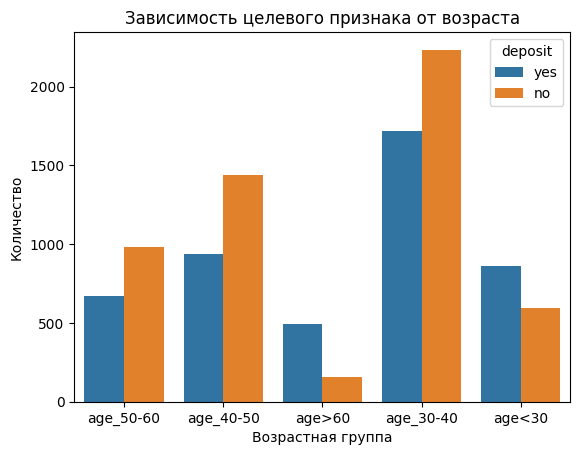

In [44]:
# функция для создания возрастных групп
def age_coder(data):
    if data < 30:
        return 'age<30'
    elif (data >= 30) & (data < 40):
        return 'age_30-40'
    elif (data >= 40) & (data < 50):
        return 'age_40-50'
    elif (data >= 50) & (data < 60):
        return 'age_50-60'
    else:
        return 'age>60'

df['age'] = df['age'].apply(age_coder)

sns.countplot(data=df, x='age', hue='deposit')

plt.title('Зависимость целевого признака от возраста')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество');

В нашем банке открывать депозиты больше склонны либо люди пенсионного возраста (60+) или молодежь (30-). При этом большую часть клиентов банка составляют люди среднего возраста. Можно порекомендовать банку уделять больше внимания возрастной группе от 30 до 60 лет.

Теперь посмотрим на вид занятости клиентов:

In [42]:
df['job'].value_counts().sort_values(ascending=False)

management       2310
blue-collar      1801
technician       1632
admin.           1246
services          865
retired           661
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         253
Name: job, dtype: int64

Основные клиенты - менеджмент среднего звеня и технические специалисты ("голубые воротники").

Посмотрим на целевой признак в зависимости от семейного статуса:

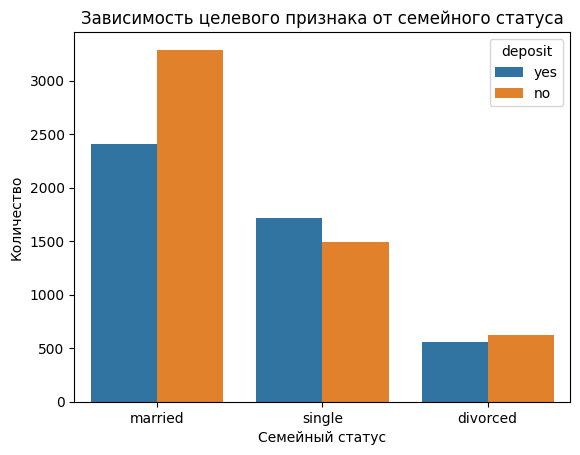

In [45]:
sns.countplot(data=df, x='marital', hue='deposit')

plt.title('Зависимость целевого признака от семейного статуса')
plt.xlabel('Семейный статус')
plt.ylabel('Количество');

Депозит склонны открывать люди, находящиеся в браке.

Посмотрим на целевой признак в зависимости от образования:

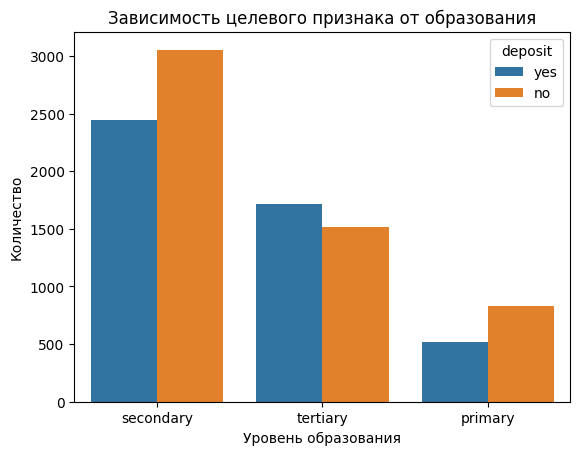

In [50]:
sns.countplot(data=df, x='education', hue='deposit')

plt.title('Зависимость целевого признака от образования')
plt.xlabel('Уровень образования')
plt.ylabel('Количество');

Основные клиенты - люди с полным школьным и высшим образованием.

Посмотрим на целевой признак в зависимости от сферы занятости:

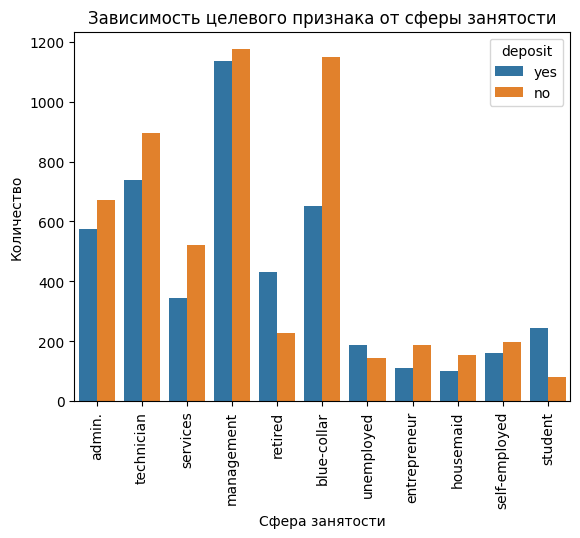

In [48]:
sns.countplot(data=df, x='job', hue='deposit');

plt.title('Зависимость целевого признака от сферы занятости')
plt.xlabel('Сфера занятости')
plt.ylabel('Количество')
plt.xticks(rotation=90);

Основные клиенты, как и говорилось ранее - менеджмент среднего звеня и технические специалисты ("голубые воротники"), что, впрочем, неплохо "бьётся" с предыдущим графиком зависимости целевого признака от уровня образования.

Построим сводную таблицу, чтобы определить, какое образование и какой семейный статус наиболее многочисленен в зависимости от того, олткрыт депозит или нет:

In [51]:
df_no = df[df['deposit'] == 'no']
df_yes = df[df['deposit'] == 'yes']

piv_no = pd.pivot_table(df_no[['deposit', 'marital', 'education']], index='marital', columns='education', aggfunc='count')
piv_yes = pd.pivot_table(df_yes[['deposit', 'marital', 'education']], index='marital', columns='education', aggfunc='count')

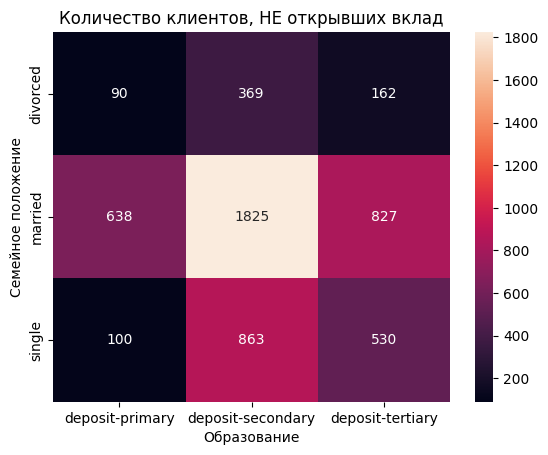

In [52]:
sns.heatmap(piv_no, annot=True, fmt='g')

plt.title('Количество клиентов, НЕ открывших вклад')
plt.xlabel('Образование')
plt.ylabel('Семейное положение');

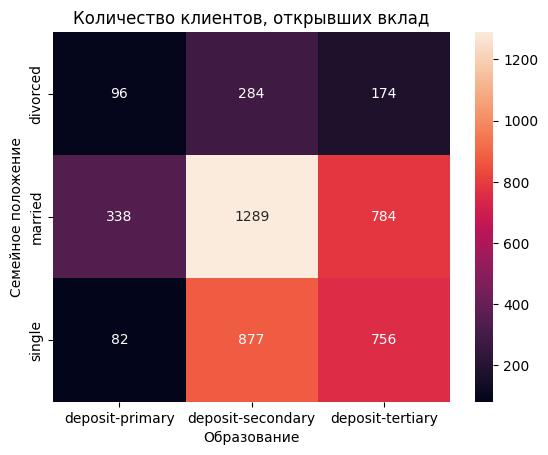

In [54]:
sns.heatmap(piv_yes, annot=True, fmt='g')

plt.title('Количество клиентов, открывших вклад')
plt.xlabel('Образование')
plt.ylabel('Семейное положение');

Графики подтверждают наши предыдущие выводы, что основными клиентами банка являются семейные люди со средним и высшим образованием.

***
### Преобразование данных.

In [55]:
# скопируем наш датасет
df_t = df.copy()
df_t.reset_index(drop=True, inplace=True)

Закодируем признаки образования и возраста порядковым кодированием:

In [58]:
encoder_education = LabelEncoder()
encoder_age = LabelEncoder()

df_education_coded = encoder_education.fit_transform(df_t['education'])
df_education_coded = pd.DataFrame(df_education_coded, columns=['education'])

df_age_coded = encoder_education.fit_transform(df_t['age'])
df_age_coded = pd.DataFrame(df_age_coded, columns=['age'])

df_t = df_t.drop(['education', 'age'], axis=1)
df_t = pd.concat([df_t, df_education_coded, df_age_coded], axis=1)

Преобразуем часть признаков в бинарные:

In [60]:
df_t['deposit'] = df_t['deposit'].apply(lambda x: 1 if x=='yes' else 0)
df_t['loan'] = df_t['loan'].apply(lambda x: 1 if x=='yes' else 0)
df_t['default'] = df_t['default'].apply(lambda x: 1 if x=='yes' else 0)
df_t['housing'] = df_t['housing'].apply(lambda x: 1 if x=='yes' else 0)

Преобразуем оставшиеся категориальные признаки с помощью однократного кодирования:

In [64]:
cols_to_code = ['job', 'marital', 'contact', 'month', 'poutcome']
df_coded = pd.get_dummies(df_t[cols_to_code])

In [65]:
df_t = df_t.drop(cols_to_code, axis=1)
df_t = pd.concat([df_t, df_coded], axis=1)

Теперь построим корреляционную матрицу:

In [71]:
# Функция для проверки корреляции.
# Принимает на вход корреляционную матрицу и целевой признак. В качестве доп. параметра есть предел
# по корреляционному коэф-ту 'thresh'.
# Возвращает датафрейм, где в 1-м столбеце - пара коррелирующих признаков со значением корреляции,
# а во 2-м и 3-м - значения корреляции каждого из двух признаков с целевым

def corr_matrix_check(corr_matrix, target, thresh=0.85):
    cols_to_drop_corr = {'pair':[], 'corr_with_target_1':[], 'corr_with_target_2':[]}
    for i, ind in enumerate(corr_matrix.index):
        cols = list(corr_matrix.columns)[i:]
        cols.remove(ind)
        for col in cols:
            corr = abs(corr_matrix.loc[ind, col])
            if corr > thresh:
                cols_to_drop_corr['pair'].append(col + '-' + ind + '=' + str(corr))
                cols_to_drop_corr['corr_with_target_1'].append(col + '=' + str(corr_matrix.loc[col, target]))
                cols_to_drop_corr['corr_with_target_2'].append(ind + '=' + str(corr_matrix.loc[ind, target]))
    return pd.DataFrame.from_dict(cols_to_drop_corr, orient='columns')

corr_matrix = round(df_t.corr(), 3)
corr_matrix_check(corr_matrix, 'deposit', thresh=0.8)

,pair,corr_with_target_1,corr_with_target_2
0,poutcome_unknown-pdays=0.824,poutcome_unknown=-0.227,pdays=0.147
1,contact_unknown-contact_cellular=0.838,contact_unknown=-0.25,contact_cellular=0.224


Удалим признаки ***pdays*** и ***contact_cellular***:

In [72]:
df_t = df_t.drop(['pdays', 'contact_cellular'], axis=1)

***
### Отбор признаков.

Разделим нашу выборку на тренировочную и тестовую:

In [73]:
X = df_t.drop(['deposit'], axis=1)
y = df_t['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

C помощью *SelectKBest* отберём $15$ наиболее подходящих признаков:

In [74]:
selector = SelectKBest(score_func=f_classif, k=15)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

filter = selector.get_support()

X_train = pd.DataFrame(X_train, columns=X.columns[filter])
X_test = pd.DataFrame(X_test, columns=X.columns[filter])

Посмотрим на оставшиеся признаки:

In [75]:
X_train.columns

Index(['balance', 'housing', 'loan', 'duration', 'campaign', 'previous', 'age',
       'job_retired', 'contact_unknown', 'month_mar', 'month_may', 'month_oct',
       'month_sep', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')

Поскольку мы будем использовать логистическую регрессию в бэйслайне, то отмасштабируем наши данные:

In [76]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

***
### Моделирование.

#### Baseline решение. Логистическая регрессия.

In [77]:
# обучите логистическую регрессию и рассчитайте метрики качества
lr = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)

lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
score = metrics.classification_report(y_test, y_test_pred)
print(score)

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1783
           1       0.83      0.78      0.80      1545

    accuracy                           0.82      3328
   macro avg       0.83      0.82      0.82      3328
weighted avg       0.82      0.82      0.82      3328



Отличные метрики! Попробуем теперь решающее дерево максимальной глубины:

#### Решающее дерево.

In [78]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

dt.fit(X_train, y_train)

y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

score_train = metrics.classification_report(y_train, y_train_pred)
score_test = metrics.classification_report(y_test, y_test_pred)

print('Тренировочная выборка:', score_train)
print('Тестовая выборка:', score_test)

Тренировочная выборка:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3621
           1       1.00      1.00      1.00      3135

    accuracy                           1.00      6756
   macro avg       1.00      1.00      1.00      6756
weighted avg       1.00      1.00      1.00      6756

Тестовая выборка:               precision    recall  f1-score   support

           0       0.77      0.76      0.77      1783
           1       0.73      0.74      0.73      1545

    accuracy                           0.75      3328
   macro avg       0.75      0.75      0.75      3328
weighted avg       0.75      0.75      0.75      3328



Посмтрим, для какой глуюины дерева метрика максимальна:

In [79]:
depth_arr = np.arange(12) + 1
acc_list = []

for depth in depth_arr:
    dt_t = tree.DecisionTreeClassifier(random_state=42, max_depth=depth)
    dt_t.fit(X_train, y_train)
    y_train_pred = dt_t.predict(X_train)
    y_test_pred = dt_t.predict(X_test)
    acc_train = round(metrics.f1_score(y_train, y_train_pred), 3)
    acc_test = round(metrics.f1_score(y_test, y_test_pred), 3)
    acc_list.append((depth, acc_train, acc_test))

acc_list

[(1, 0.716, 0.693),
 (2, 0.755, 0.743),
 (3, 0.777, 0.764),
 (4, 0.779, 0.768),
 (5, 0.797, 0.789),
 (6, 0.813, 0.8),
 (7, 0.823, 0.803),
 (8, 0.833, 0.798),
 (9, 0.845, 0.794),
 (10, 0.858, 0.793),
 (11, 0.873, 0.786),
 (12, 0.886, 0.785)]

Оптимальная глубина дерева - $7$ с показателем *$F_1$* = $0.803$ на тестовой выборке.

Теперь попробуем подобрать гиперпараметры с помощшью *GridSearchCV*:

In [85]:
# подберите оптимальные параметры с помощью gridsearch
params = {'min_samples_split': [2, 5, 7, 10], 'max_depth':[5, 7, 9]}

model_ = tree.DecisionTreeClassifier(random_state=42)

gs = GridSearchCV(estimator=model_, param_grid=params, scoring='f1', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

dt_b = tree.DecisionTreeClassifier(random_state=42, **gs.best_params_)
dt_b.fit(X_train, y_train)

y_test_pred = dt_b.predict(X_test)

f1_test = metrics.f1_score(y_test, y_test_pred)
round(f1_test, 3)

0.789

Выведем наилучшие гиперпараметры:

In [84]:
gs.best_params_

{'max_depth': 5, 'min_samples_split': 2}

Однако не самая высокая метрика. Теперь перейдём к ансамблевым моделям:

#### Случайный лес.

In [88]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

score_train = metrics.classification_report(y_train, y_train_pred)
score_test = metrics.classification_report(y_test, y_test_pred)

print('Тренировочная выборка:\n', score_train)
print('Тестовая выборка:\n', score_test)

Тренировочная выборка:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      3621
           1       0.83      0.87      0.85      3135

    accuracy                           0.85      6756
   macro avg       0.85      0.85      0.85      6756
weighted avg       0.85      0.85      0.85      6756

Тестовая выборка:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1783
           1       0.80      0.85      0.82      1545

    accuracy                           0.83      3328
   macro avg       0.83      0.83      0.83      3328
weighted avg       0.83      0.83      0.83      3328



#### Градиентный бустинг.

In [91]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=7,
    random_state=42
)
gb.fit(X_train, y_train)

y_test_pred = gb.predict(X_test)

f1_test = metrics.f1_score(y_test, y_test_pred)
round(f1_test, 3)

0.82

Примерно то же самое значение метрики *$F_1$*, что и для случайного леса, но при этом модель на градиентном бустинге требует больше времени на обучение. Вероятно, стоит подобрать оптимальные параметры с помощью, например, ***Optuna***.

#### Стекинг.

Объединим наши алгоритмы с помощью стекинга:

In [92]:
rf_s = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
gb_s = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
dt_s = tree.DecisionTreeClassifier(
    max_depth=7,
    min_samples_split=10
)
lr = linear_model.LogisticRegression()

estimators = [
    ('rf', rf_s),
    ('gb', gb_s),
    ('dt', dt_s)
]

stack = ensemble.StackingClassifier(estimators=estimators, final_estimator=lr, n_jobs=-1)

stack.fit(X_train, y_train)

y_test_pred = stack.predict(X_test)

precision_stack = metrics.precision_score(y_test, y_test_pred)
print(round(precision_stack, 3))

0.801


Метрика хуже, чем уже была получена в моделях случайного леса и градиентного бустинга.

Теперь всё-таки попробуем улучшить наши модели на случайном лесе и градиентом бустинге с помощью подбора гиперпараметров. Будем использовать *Optuna* с кросс-валидацией:

In [99]:
def optuna_rf(trial, cv=5):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    model_rf = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
    )
   
    score = cross_val_score(model_rf, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1).mean()
    return score

study_rf = optuna.create_study(study_name="RandomForest", direction="maximize")
study_rf.optimize(optuna_rf, n_trials=32)

print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.4f}".format(study_rf.best_value))

[I 2023-11-29 20:00:13,117] A new study created in memory with name: RandomForest
[I 2023-11-29 20:00:14,095] Trial 0 finished with value: 0.8244709849667373 and parameters: {'n_estimators': 168, 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8244709849667373.
[I 2023-11-29 20:00:14,636] Trial 1 finished with value: 0.8214869770575403 and parameters: {'n_estimators': 108, 'max_depth': 20, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8244709849667373.
[I 2023-11-29 20:00:15,281] Trial 2 finished with value: 0.8267538807458854 and parameters: {'n_estimators': 114, 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8267538807458854.
[I 2023-11-29 20:00:15,959] Trial 3 finished with value: 0.8211443009178009 and parameters: {'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8267538807458854.
[I 2023-11-29 20:00:16,853] Trial 4 finished with value: 0.8208875191644378 and parameters: {'n_estimators

Наилучшие значения гиперпараметров {'n_estimators': 100, 'max_depth': 28, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.8277


In [100]:
def optuna_rf(trial, cv=5):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 4, 16, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)

    model_gb = ensemble.GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
    )
   
    score = cross_val_score(model_gb, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1).mean()
    return score

study_gb = optuna.create_study(study_name="GradientBoosting", direction="maximize")
study_gb.optimize(optuna_rf, n_trials=32)

print("Наилучшие значения гиперпараметров {}".format(study_gb.best_params))
print("f1_score на обучающем наборе: {:.4f}".format(study_gb.best_value))

[I 2023-11-29 20:00:36,921] A new study created in memory with name: GradientBoosting
[I 2023-11-29 20:00:38,415] Trial 0 finished with value: 0.8217764150462845 and parameters: {'n_estimators': 111, 'max_depth': 6, 'min_samples_leaf': 3, 'learning_rate': 0.09230623938116106}. Best is trial 0 with value: 0.8217764150462845.
[I 2023-11-29 20:00:42,945] Trial 1 finished with value: 0.8058068821542314 and parameters: {'n_estimators': 147, 'max_depth': 14, 'min_samples_leaf': 8, 'learning_rate': 0.05772176540192311}. Best is trial 0 with value: 0.8217764150462845.
[I 2023-11-29 20:00:49,753] Trial 2 finished with value: 0.7936602867419789 and parameters: {'n_estimators': 133, 'max_depth': 14, 'min_samples_leaf': 3, 'learning_rate': 0.011440936237273028}. Best is trial 0 with value: 0.8217764150462845.
[I 2023-11-29 20:00:51,567] Trial 3 finished with value: 0.8083568866214875 and parameters: {'n_estimators': 139, 'max_depth': 6, 'min_samples_leaf': 4, 'learning_rate': 0.19518190239851496}.

Наилучшие значения гиперпараметров {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 3, 'learning_rate': 0.08904381528921451}
f1_score на обучающем наборе: 0.8267


Итак, лучшей моделью по итогу оказался случайный лес со следующими параметрами:
- *n_estimators* = 100,
- *max_depth' = 28,
- *min_samples_leaf* = 5

Метрики получились практически одинаковы, но случайный лес заметно быстрее.

Теперь поглядим на наиболее важные признаки в нашем случйном лесу:

In [102]:
model_best = ensemble.RandomForestClassifier(**study_rf.best_params)
model_best.fit(X_train, y_train)

f_imp = pd.Series(model_best.feature_importances_)
f_name = pd.Series(model_best.feature_names_in_)
df_imp = pd.concat([f_name, f_imp], axis=1)
df_imp.columns = ['name', 'importance']

df_imp.sort_values(by='importance', ascending=False)

,name,importance
3,duration,0.529387
0,balance,0.078741
13,poutcome_success,0.075487
8,contact_unknown,0.057429
6,age,0.050751
1,housing,0.040973
4,campaign,0.030748
5,previous,0.029468
14,poutcome_unknown,0.024954
10,month_may,0.021722


Сделаем предсказания на самой лучшей модели:

In [103]:
y_test_pred = model_best.predict(X_test)

f1_best = round(metrics.f1_score(y_test, y_test_pred), 3)
acc_best = round(metrics.accuracy_score(y_test, y_test_pred), 3)

print(f'F1 на тесте: {f1_best}, accuracy на тесте: {acc_best}')

F1 на тесте: 0.826, accuracy на тесте: 0.833


Площадь под кривой ошибок:

In [104]:
roc_auc = metrics.roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC = {round(roc_auc, 3)}')

ROC AUC = 0.834


Итак, мы построили модель на основе случайного леса, которая показала на тестовой выборке $F_1\ =\ 0.826$.